In [2]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
image = Image.open('/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg').convert('RGB')
image_np = np.array(image)
image_reshaped = image_np.reshape(-1, 3) / 255.0

/home/yec23006/.conda/envs/torch121/lib/python3.11/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (163440432 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


# Without Embedding

In [ ]:
# Brown and Yellow
brown_colors = np.array([
    [173, 109, 66], [154, 94, 50], [202, 144, 97], [206, 130, 63], [161, 119, 94]
]) / 255.0

image_reshaped = image_np.reshape(-1, 3) / 255.0
distances = np.linalg.norm(image_reshaped[:, None, :] - brown_colors[None, :, :], axis=2)
closest_cluster = np.argmin(distances, axis=1)
min_distances = np.min(distances, axis=1)

# Threshold to decide which pixels are "brown" (tunable parameter)
brown_threshold = 0.15  # The smaller, the stricter the selection
brown_mask = (min_distances < brown_threshold).reshape(image_np.shape[:2])

segmented_image = np.zeros_like(image_np)
segmented_image[brown_mask] = image_np[brown_mask]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(segmented_image)
axes[1].set_title("Segmented Brown Areas")
axes[1].axis("off")

plt.show()

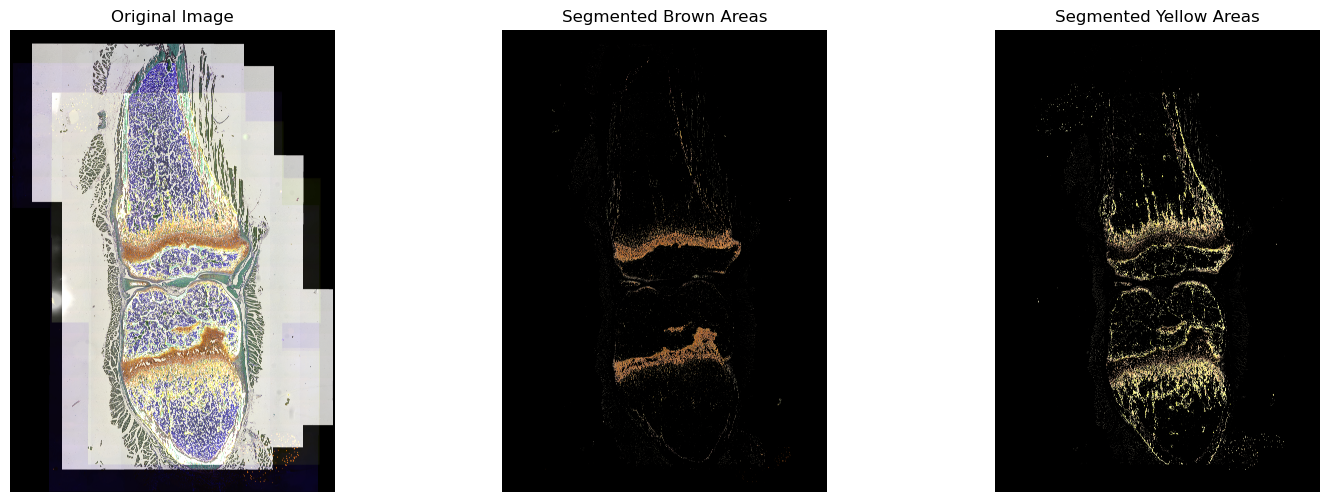

In [7]:
# Separate Brown and Yellow
# Define the yellow color cluster from the embedding space
yellow_colors = np.array([
    [238, 225, 156], [245, 207, 136], [200, 177, 127], [255, 254, 174], [251, 240, 113]
]) / 255.0
brown_colors = np.array([
    [173, 109, 66], [154, 94, 50], [202, 144, 97], [206, 130, 63], [161, 119, 94]
]) / 255.0

# Compute Euclidean distance between each pixel and yellow cluster centers
distances_brown = np.linalg.norm(image_reshaped[:, None, :] - brown_colors[None, :, :], axis=2)
distances_yellow = np.linalg.norm(image_reshaped[:, None, :] - yellow_colors[None, :, :], axis=2)

# Find the closest cluster for each pixel
min_distances_yellow = np.min(distances_yellow, axis=1)
min_distances_brown = np.min(distances_brown, axis=1)

# Threshold to decide which pixels are "yellow" (tunable parameter)
threshold = 0.15  # Adjust this to refine the selection
yellow_mask = (min_distances_yellow < threshold).reshape(image_np.shape[:2])
brown_mask = (min_distances_brown < threshold).reshape(image_np.shape[:2])

# Remove yellow areas from the brown mask
brown_mask_refined = np.logical_and(brown_mask, ~yellow_mask)

# Create the refined segmented brown image
segmented_brown = np.zeros_like(image_np)
segmented_brown[brown_mask_refined] = image_np[brown_mask_refined]

# Create the segmented yellow image
segmented_yellow = np.zeros_like(image_np)
segmented_yellow[yellow_mask] = image_np[yellow_mask]

# Display the refined segmentation results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(segmented_brown)
axes[1].set_title("Segmented Brown Areas")
axes[1].axis("off")

axes[2].imshow(segmented_yellow)
axes[2].set_title("Segmented Yellow Areas")
axes[2].axis("off")

plt.show()


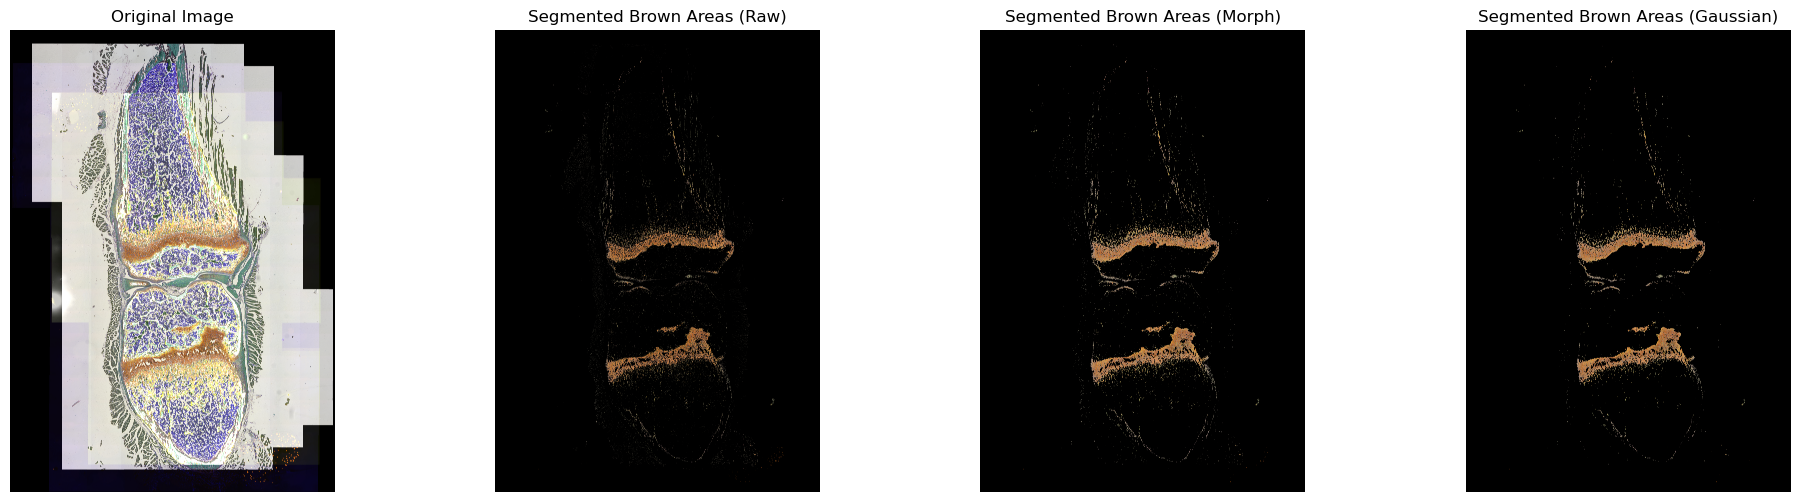

In [13]:
# Morphology
kernel = np.ones((5, 5), np.uint8)  # Define a small kernel

# Perform morphological closing (dilation followed by erosion) to fill gaps
brown_mask_smoothed = cv2.morphologyEx(segmented_brown.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=2)

# Perform morphological opening (erosion followed by dilation) to remove noise
brown_mask_smoothed = cv2.morphologyEx(brown_mask_smoothed, cv2.MORPH_OPEN, kernel, iterations=1)

# Denoise
brown_mask_denoised = cv2.morphologyEx(brown_mask_smoothed, cv2.MORPH_OPEN, kernel, iterations=2)

# Apply Gaussian Blur
brown_mask_blurred = cv2.GaussianBlur(brown_mask_denoised, (5, 5), sigmaX=2, sigmaY=2)

# Display the original, raw mask, and smoothed segmented images
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(segmented_brown)
axes[1].set_title("Segmented Brown Areas (Raw)")
axes[1].axis("off")

axes[2].imshow(brown_mask_smoothed)
axes[2].set_title("Segmented Brown Areas (Morph)")
axes[2].axis("off")

axes[3].imshow(brown_mask_blurred)
axes[3].set_title("Segmented Brown Areas (Gaussian)")
axes[3].axis("off")

plt.show()


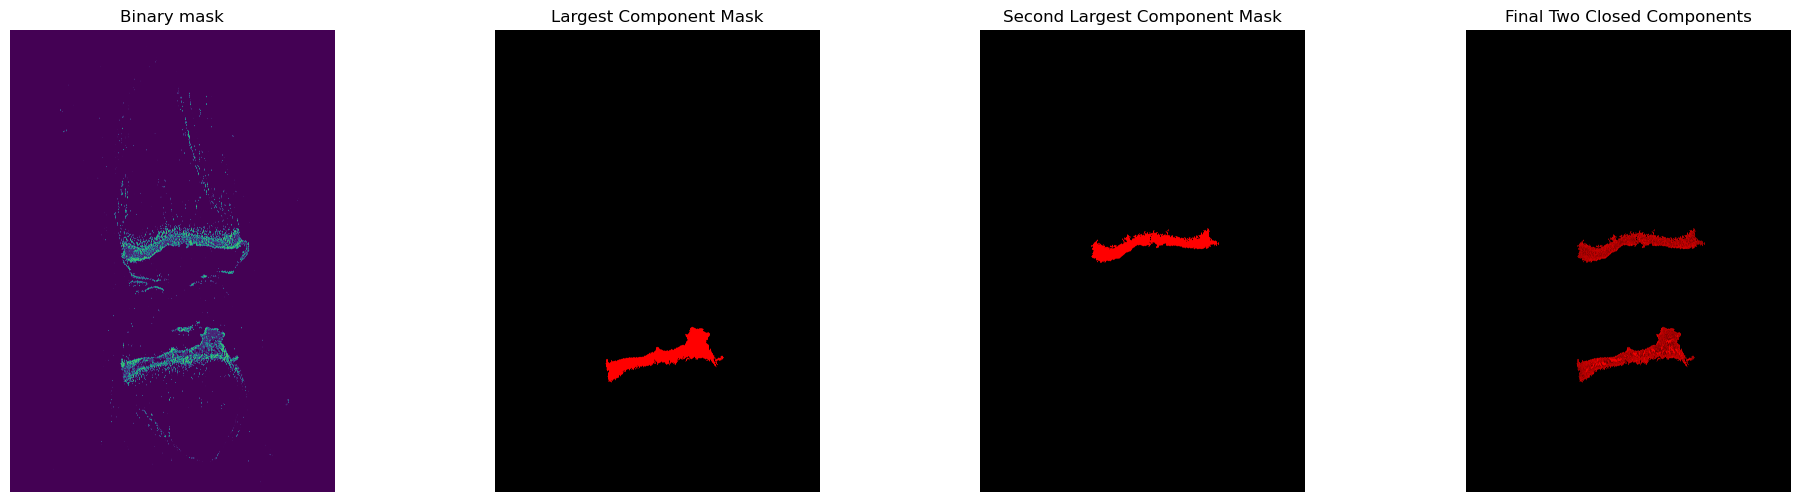

In [24]:

brown_mask_binary = cv2.threshold(brown_mask_denoised, 127, 255, cv2.THRESH_BINARY)[1]
brown_mask_binary = cv2.cvtColor(brown_mask_binary, cv2.COLOR_BGR2GRAY)
brown_mask_binary = brown_mask_binary.astype(np.uint8)

contours, _ = cv2.findContours(brown_mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

mask1 = np.zeros_like(brown_mask_denoised)
mask2 = np.zeros_like(brown_mask_denoised)

if len(contours) > 0:
    cv2.drawContours(mask1, [contours[0]], -1, 255, thickness=cv2.FILLED)
if len(contours) > 1:
    cv2.drawContours(mask2, [contours[1]], -1, 255, thickness=cv2.FILLED)

mask1_closed = cv2.morphologyEx(mask1, cv2.MORPH_CLOSE, kernel, iterations=3)
mask2_closed = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel, iterations=3)

# Separate two components
segmented_brown_component1 = np.zeros_like(image_np)
segmented_brown_component2 = np.zeros_like(image_np)
segmented_brown_component1[mask1_closed == 255] = image_np[mask1_closed == 255]
segmented_brown_component2[mask2_closed == 255] = image_np[mask2_closed == 255]

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].imshow(brown_mask_binary)
axes[0].set_title("Binary mask")
axes[0].axis("off")

axes[1].imshow(mask1_closed, cmap="gray")
axes[1].set_title("Largest Component Mask")
axes[1].axis("off")

axes[2].imshow(mask2_closed, cmap="gray")
axes[2].set_title("Second Largest Component Mask")
axes[2].axis("off")

axes[3].imshow(segmented_brown_component1 + segmented_brown_component2)
axes[3].set_title("Final Two Closed Components")
axes[3].axis("off")

plt.show()


# With Embedding

In [3]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2lab
import random


In [58]:
image = Image.open('/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg').convert('RGB')
image_np = np.array(image)

image_pixels = image_np.reshape(-1, 3) / 255.0
image_pixels_tensor = torch.tensor(image_pixels, dtype=torch.float32)

/home/yec23006/.conda/envs/torch121/lib/python3.11/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (163440432 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


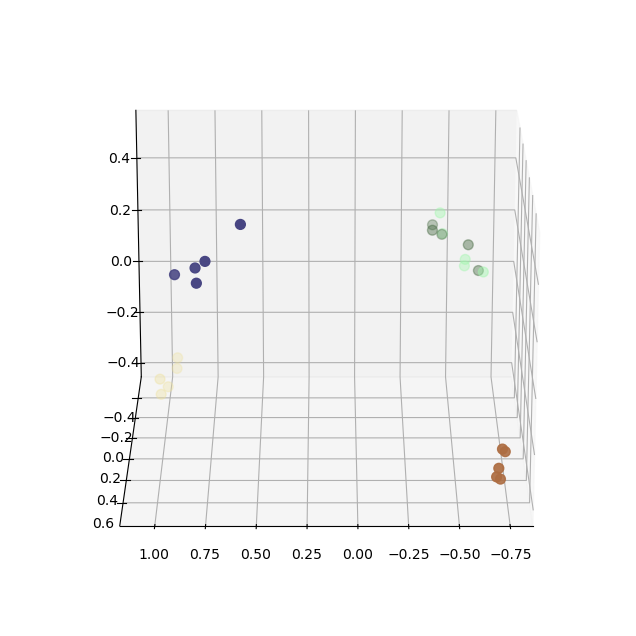

In [4]:
random.seed(42)
# Convert group colors to tensors and normalize them
colors = [torch.tensor(group, dtype = torch.float32)/255.0 for group in [
    np.array([[71, 69, 130], [52, 40, 127], [189, 179, 201], [144, 139, 215], [93, 85, 133]]),  # Blue
    np.array([[173, 109, 66], [154, 94, 50], [202, 144, 97], [206, 130, 63], [161, 119, 94]]),  # Brown
    np.array([[67, 103, 62], [100, 117, 71], [112, 141, 109], [83, 97, 61], [104, 127, 121]]),  # Green
    np.array([[160, 247, 172], [191, 227, 205], [162, 213, 184], [175, 226, 161], [164, 210, 182]]), #Mint
    np.array([[238, 225, 156], [245, 207, 136], [200, 177, 127], [255, 254, 174], [251, 240, 113]])  # Yellow
]]


# Flatten and store cluster labels
X = torch.cat(colors)
y = torch.cat([torch.full((len(group),), i) for i, group in enumerate(colors)])

# Normalize to unit sphere
X = X / torch.norm(X, dim=1, keepdim=True)

# Learnable CNN-based embeddings
embedding_dim = 5
class ClusterEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_clusters):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, embedding_dim)
        )
        self.cluster_centers = nn.Parameter(torch.randn(num_clusters, embedding_dim))

    def forward(self, x):
        x = self.fc(x)
        x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize embeddings
        return x

def contrastive_loss(embeddings, labels, cluster_centers, margin=3.0):  # Increased margin
    intra_loss = 0  
    inter_loss = 0  
    num_clusters = cluster_centers.shape[0]
    
    # Intra-cluster compactness: Pull embeddings closer to their assigned cluster center
    for i in range(num_clusters):
        cluster_embeds = embeddings[labels == i]
        if cluster_embeds.shape[0] > 1:
            intra_loss += torch.mean(1 - torch.cosine_similarity(cluster_embeds, cluster_centers[i].unsqueeze(0)))

    # Inter-cluster separation: Push clusters apart based on similarity
    num_pairs = 0
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                similarity = torch.cosine_similarity(cluster_centers[i].unsqueeze(0), cluster_centers[j].unsqueeze(0))
                distance_penalty = torch.exp(-torch.norm(cluster_centers[i] - cluster_centers[j]))  # Exponential scaling
                inter_loss += torch.clamp(margin - similarity, min=0) * distance_penalty  # Stronger push

                num_pairs += 1

    inter_loss /= num_pairs  # Normalize
    return intra_loss + 3.0 * inter_loss  # Increase weight of inter-cluster loss




model = ClusterEmbedding(input_dim=3, embedding_dim=embedding_dim, num_clusters=len(colors))
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    embeddings = model(X)
    loss = contrastive_loss(embeddings, y, model.cluster_centers) 
    loss.backward()
    optimizer.step()

# Visualize embeddings
# Define the original colors in RGB (normalized to [0,1])
cluster_colors = np.array([
    [71, 69, 130],   # Blue
    [173, 109, 66],  # Brown
    [67, 103, 62],   # Green
    [160, 247, 172], # Mint
    [238, 225, 156]  # Yellow
]) / 255.0  # Normalize to [0,1]

# Convert cluster labels to corresponding colors
point_colors = np.array([cluster_colors[label] for label in y.numpy()])

pca = PCA(n_components=3)
projected_embeddings = pca.fit_transform(model(X).detach().numpy())

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], projected_embeddings[:, 2], color=point_colors, s=50)
# plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], projected_embeddings[:, 2], color=point_colors, s=50)
ax.view_init(elev=20, azim=90)

plt.show()



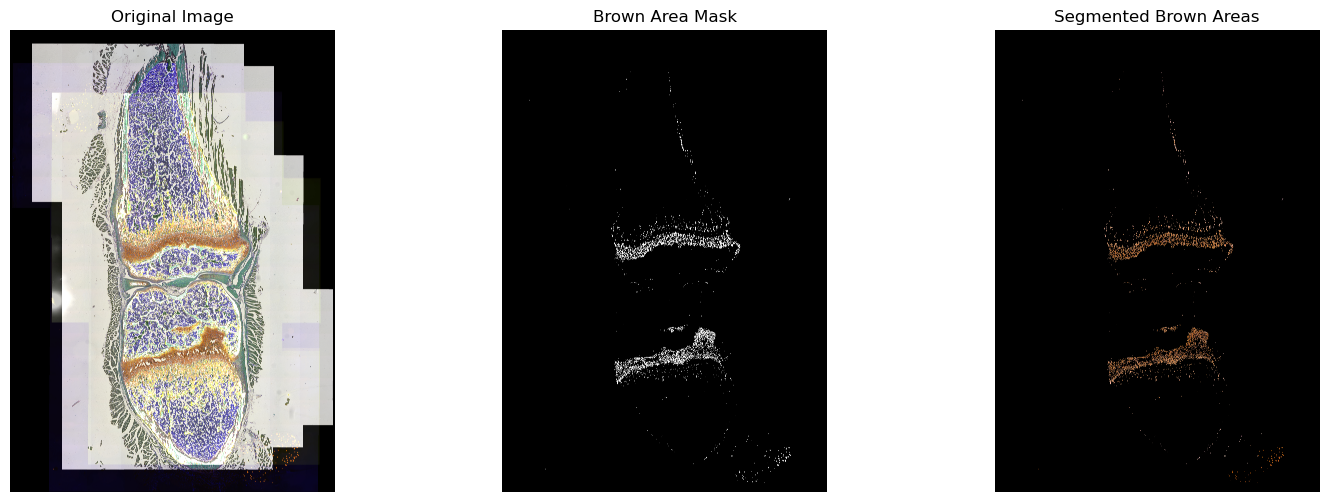

In [5]:
# Project image pixels into the trained embedding space
with torch.no_grad():
    pixel_embeddings = model(image_pixels_tensor)

# Extract the embedding of the brown cluster from the trained model
brown_cluster_idx = 1  # Adjust if needed
brown_center = model.cluster_centers[brown_cluster_idx]

# Compute cosine similarity between each pixel and brown cluster center
cosine_similarities = torch.cosine_similarity(pixel_embeddings, brown_center.unsqueeze(0), dim=1)

# Create a mask based on similarity threshold
brown_threshold = 0.9  # Adjust as needed
brown_mask = (cosine_similarities > brown_threshold).numpy().reshape(image_np.shape[:2])

# Convert mask to binary image and apply morphological processing
brown_mask_binary = (brown_mask * 255).astype(np.uint8)
kernel = np.ones((5, 5), np.uint8)
brown_mask_denoised = cv2.morphologyEx(brown_mask_binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Apply mask to extract brown areas
segmented_brown = np.zeros_like(image_np)
segmented_brown[brown_mask_denoised == 255] = image_np[brown_mask_denoised == 255]

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(brown_mask_denoised, cmap="gray")
axes[1].set_title("Brown Area Mask")
axes[1].axis("off")

axes[2].imshow(segmented_brown)
axes[2].set_title("Segmented Brown Areas")
axes[2].axis("off")

plt.show()


In [ ]:
brown_mask_denoised.shape, segmented_brown.shape, image_np.shape, np.unique(brown)

((15252, 10716), (15252, 10716, 3), (15252, 10716, 3))

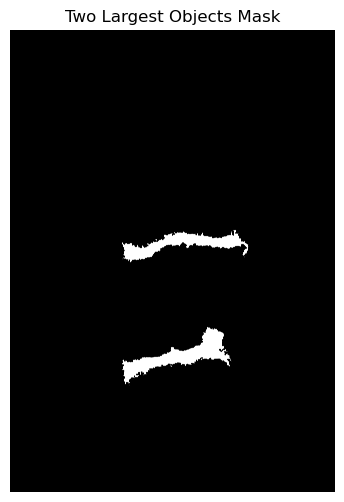

False

In [ ]:
from scipy.ndimage import binary_fill_holes, label

# Apply morphological operations to clean up the segmentation mask
kernel = np.ones((5,5), np.uint8)

# Perform morphological closing to fill small holes
closed_mask = cv2.morphologyEx(brown_mask_denoised, cv2.MORPH_CLOSE, kernel, iterations=10)

# Perform morphological opening to remove noise
morph_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel, iterations=2)
filled_mask = binary_fill_holes(morph_mask).astype(np.uint8)
labeled_mask, num_features = label(filled_mask)

unique, counts = np.unique(labeled_mask, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]

if len(sorted_indices) > 2:
    largest_label = unique[sorted_indices[1]]
    second_largest_label = unique[sorted_indices[2]]

    # Create a mask with only the two largest objects
    final_selected_mask = np.logical_or(
        labeled_mask == largest_label, labeled_mask == second_largest_label
    ).astype(np.uint8) * 255
else:
    final_selected_mask = filled_mask * 255

plt.figure(figsize=(6, 6))
plt.imshow(final_selected_mask, cmap='gray')
plt.title("Two Largest Objects Mask")
plt.axis("off")
plt.show()


# Save the refined mask
refined_mask_path = "/home/yec23006/projects/research/KneeGrowthPlate/results/embedding/segmentation_mask_No_Gaussian.png"
cv2.imwrite(refined_mask_path, final_selected_mask)

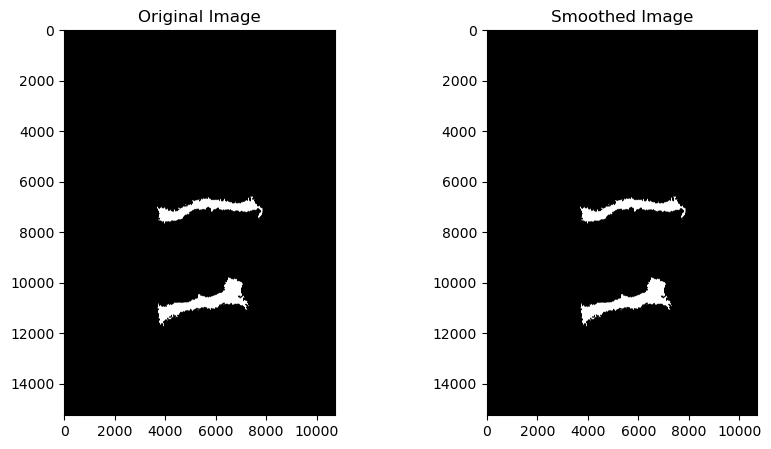

True

In [48]:
kernel = np.ones((5,5), np.uint8)
image_closed = cv2.morphologyEx(final_selected_mask, cv2.MORPH_CLOSE, kernel)

# Apply Gaussian Blur to further smoothen the edges
image_blurred = cv2.GaussianBlur(image_closed, (5,5), 0)

# Convert back to binary
_, image_smoothed = cv2.threshold(image_blurred, 127, 255, cv2.THRESH_BINARY)

# Show the result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(final_selected_mask, cmap='gray')

plt.subplot(1,2,2)
plt.title("Smoothed Image")
plt.imshow(image_smoothed, cmap='gray')

plt.show()

refined_mask_path = "/home/yec23006/projects/research/KneeGrowthPlate/results/embedding/segmentation_mask.png"
cv2.imwrite(refined_mask_path, image_smoothed)

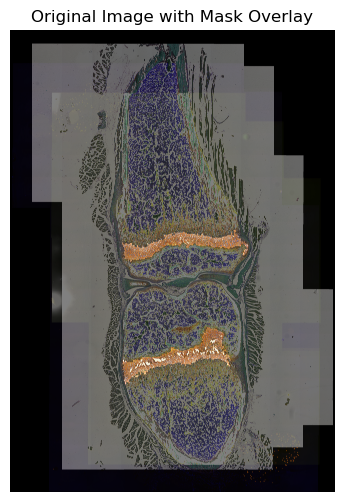

In [65]:
mask_bgr = cv2.cvtColor(image_smoothed, cv2.COLOR_GRAY2BGR)


mask_rgba = np.zeros((mask_bgr.shape[0], mask_bgr.shape[1], 4), dtype=np.uint8)
mask_rgba[:, :, :3] = mask_bgr  
mask_rgba[:, :, 3] = (image_smoothed == 0) * int(0.5 * 255)  # Set alpha based on mask

image_pil = Image.fromarray(image_np)
mask_pil = Image.fromarray(mask_rgba, mode="RGBA")

overlay = Image.alpha_composite(image_pil.convert("RGBA"), mask_pil)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis('off')
plt.title("Original Image with Mask Overlay")
plt.show()

path2save = "/home/yec23006/projects/research/KneeGrowthPlate/results/embedding/overlay.png"
overlay.save(path2save)

# Patch classification

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

In [2]:
path2mask = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/segmentation_mask.png'
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'

image = Image.open(path2img).convert('RGB')
image_np = np.array(image)

mask = Image.open(path2mask).convert('L')
mask_np = np.array(mask)

print(image_np.shape, mask_np.shape)

/home/yec23006/.conda/envs/torch121/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (163440432 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(15252, 10716, 3) (15252, 10716)


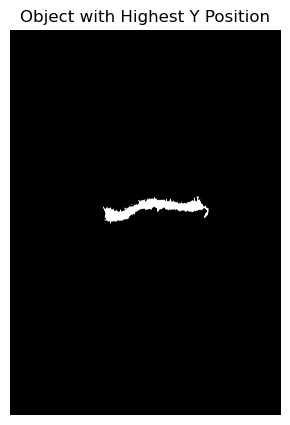

In [3]:
# Select the knee growth plate
mask_img = cv2.imread(path2mask, cv2.IMREAD_GRAYSCALE)

# Find connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_img, connectivity=8)

object_stats = stats[1:]  
object_centroids = centroids[1:]


kgp_y_idx = np.argmin(object_stats[:, 1])

# Create an empty mask and draw only the selected object
selected_object = (labels == (kgp_y_idx + 1)).astype(np.uint8) * 255
selected_object_img = Image.fromarray(selected_object)
selected_object_img.save('/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/growthplate_mask.png')
plt.figure(figsize=(5,5))
plt.imshow(selected_object, cmap='gray')
plt.axis("off")
plt.title("Object with Highest Y Position")
plt.show()


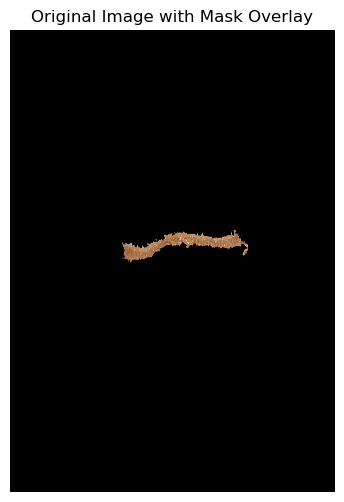

In [16]:
overlap = image_np * (selected_object[:, :, np.newaxis] // 255)

plt.figure(figsize=(6,6))
plt.imshow(overlap)
plt.axis('off')
plt.title("Original Image with Mask Overlay")
plt.show()

overlap_img = Image.fromarray(overlap)
path2save = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/overlay_extraction.png"
overlap_img.save(path2save)

In [ ]:
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'
image = cv2.imread(path2img, cv2.IMREAD_COLOR)

image.

Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


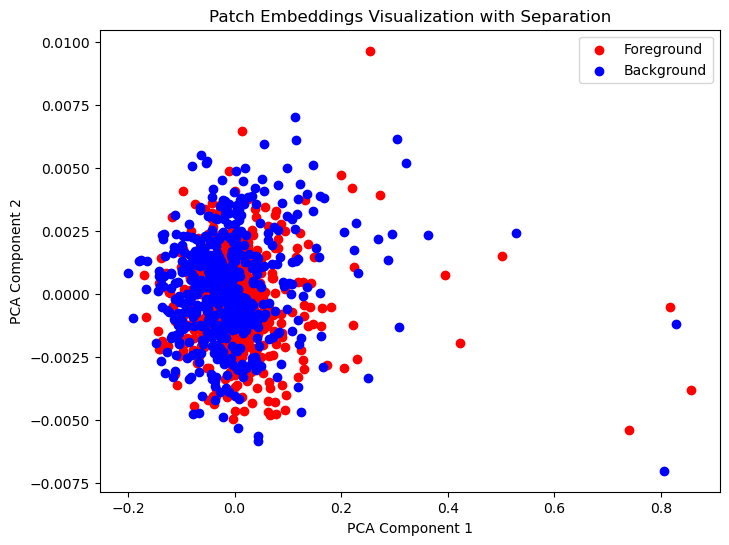

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset

# Load images in RGB scale
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'
path2platemask = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/growthplate_mask.png'
path2columnar = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/columnar_mask.png'

image = cv2.imread(path2img, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
platemask = cv2.imread(path2platemask, cv2.IMREAD_GRAYSCALE)
columnarmask = cv2.imread(path2columnar, cv2.IMREAD_GRAYSCALE)

# Define patch extraction function for RGB images
def extract_patches(image, platemask, columnarmask, patch_size=16, num_patches=1000, foreground=True):
    h, w, _ = image.shape
    patches = []

    selected_mask = columnarmask if foreground else (platemask - columnarmask)
    selected_mask = np.clip(selected_mask, 0, 255)

    valid_points = np.argwhere(selected_mask > 128)

    for _ in range(num_patches):
        if len(valid_points) == 0:
            break
        y, x = valid_points[np.random.randint(0, len(valid_points))]
        x = max(0, min(x, w - patch_size))
        y = max(0, min(y, h - patch_size))
        patch = image[y:y+patch_size, x:x+patch_size, :]
        patches.append(patch)
    
    return np.array(patches)

# Extract patches
patch_size = 64
num_patches = 500
foreground_patches = extract_patches(image, platemask, columnarmask, patch_size, num_patches, foreground=True)
background_patches = extract_patches(image, platemask, columnarmask, patch_size, num_patches, foreground=False)

# Normalize and reshape patches
all_patches = np.vstack((foreground_patches, background_patches))
labels = np.array([1] * num_patches + [0] * num_patches)
all_patches = all_patches.astype(np.float32) / 255.0
all_patches = np.transpose(all_patches, (0, 3, 1, 2))  # Convert to (batch, channels, height, width)

# Define a simple embedding network
class PatchEmbeddingNet(nn.Module):
    def __init__(self):
        super(PatchEmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (patch_size // 4) * (patch_size // 4), 128)  # Adjusted to match conv output size
        self.fc2 = nn.Linear(128, 2)  # 2D embedding space for separation
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.nn.functional.adaptive_avg_pool2d(x, (patch_size // 4, patch_size // 4))  # Ensure fixed-size flattening
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the embedding model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchEmbeddingNet().to(device)
criterion = nn.CosineEmbeddingLoss(margin=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare data
data_tensor = torch.tensor(all_patches).to(device)
label_tensor = torch.tensor(labels * 2 - 1, dtype=torch.float32).to(device)  # Convert labels to [-1, 1] for CosineEmbeddingLoss

data_loader = DataLoader(TensorDataset(data_tensor, label_tensor), batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, batch_labels in data_loader:
        optimizer.zero_grad()
        embeddings = model(batch_data)
        target_embeddings = torch.ones_like(embeddings) * batch_labels.view(-1, 1).to(device)  # Separate classes
        loss = criterion(embeddings, target_embeddings, batch_labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract embeddings
with torch.no_grad():
    embeddings = model(data_tensor).cpu().numpy()

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:num_patches, 0], reduced_embeddings[:num_patches, 1], c='r', label='Foreground')
plt.scatter(reduced_embeddings[num_patches:, 0], reduced_embeddings[num_patches:, 1], c='b', label='Background')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Patch Embeddings Visualization with Separation")
plt.show()


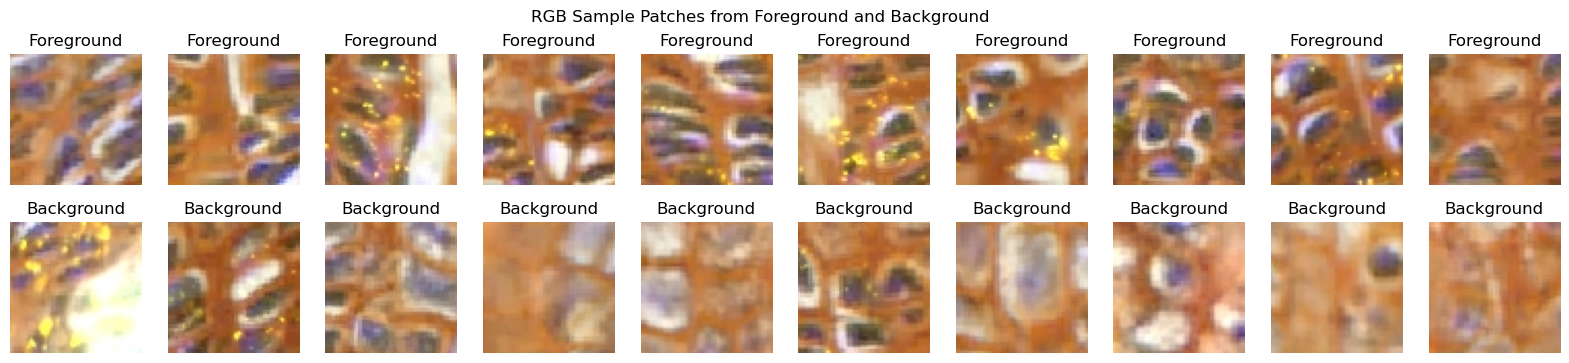

In [22]:
# Load images in RGB scale
image_rgb = cv2.imread(path2img, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Define patch extraction function for RGB images
def extract_patches_rgb(image, mask, platemask_columnarmask, columnarmask, patch_size=32, num_patches=10, foreground=True):
    h, w, _ = image.shape
    patches = []
    
    # Select appropriate mask for extraction
    selected_mask = columnarmask if foreground else (platemask_columnarmask - columnarmask)
    selected_mask = np.clip(selected_mask, 0, 255)  # Ensure valid mask range
    
    # Extract patch locations
    valid_points = np.argwhere(selected_mask > 128)
    
    for _ in range(num_patches):
        if len(valid_points) == 0:
            break
        y, x = valid_points[np.random.randint(0, len(valid_points))]
        x = max(0, min(x, w - patch_size))
        y = max(0, min(y, h - patch_size))
        patch = image[y:y+patch_size, x:x+patch_size, :]
        patches.append(patch)
    
    return np.array(patches)

# Extract 10 patches for visualization
foreground_patches_rgb = extract_patches_rgb(image_rgb, mask, platemask, columnarmask, 64, 10, foreground=True)
background_patches_rgb = extract_patches_rgb(image_rgb, mask, platemask, columnarmask, 64, 10, foreground=False)

# Create figure for visualization
num_foreground = len(foreground_patches_rgb)
num_background = len(background_patches_rgb)
num_visualize = min(num_patches, num_foreground, num_background)

fig, axes = plt.subplots(2, num_visualize, figsize=(num_visualize * 2, 4))

for i in range(num_visualize):
    # Foreground patches
    axes[0, i].imshow(foreground_patches_rgb[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("Foreground")

    # Background patches
    axes[1, i].imshow(background_patches_rgb[i])
    axes[1, i].axis("off")
    axes[1, i].set_title("Background")

plt.suptitle("RGB Sample Patches from Foreground and Background")
plt.show()


Epoch [1/10], Loss: 0.5703
Epoch [2/10], Loss: 0.6639
Epoch [3/10], Loss: 0.4955
Epoch [4/10], Loss: 1.5771
Epoch [5/10], Loss: 1.5572
Epoch [6/10], Loss: 0.6556
Epoch [7/10], Loss: 0.8168
Epoch [8/10], Loss: 1.6244
Epoch [9/10], Loss: 1.1343
Epoch [10/10], Loss: 0.7327


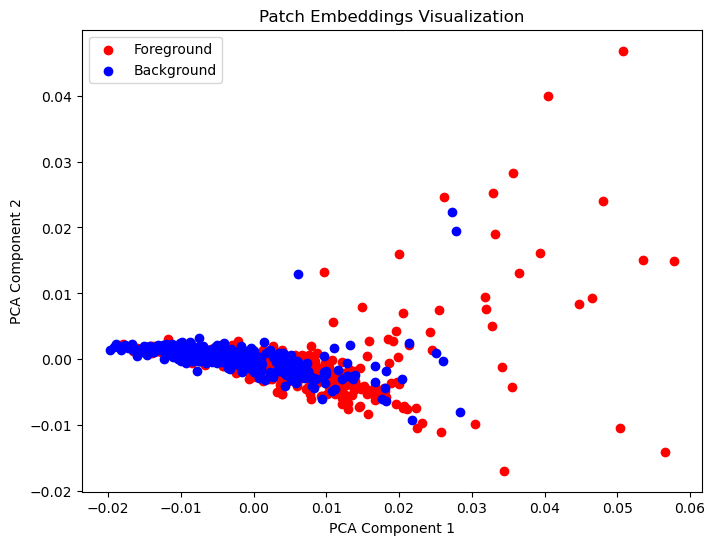

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset

# Load images in RGB scale
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'
path2platemask = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/growthplate_mask.png'
path2columnar = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/columnar_mask.png'

image = cv2.imread(path2img, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
platemask = cv2.imread(path2platemask, cv2.IMREAD_GRAYSCALE)
columnarmask = cv2.imread(path2columnar, cv2.IMREAD_GRAYSCALE)

# Define patch extraction function for RGB images
def extract_patches(image, platemask, columnarmask, patch_size=16, num_patches=1000, foreground=True):
    h, w, _ = image.shape
    patches = []

    selected_mask = columnarmask if foreground else (platemask - columnarmask)
    selected_mask = np.clip(selected_mask, 0, 255)

    valid_points = np.argwhere(selected_mask > 128)

    for _ in range(num_patches):
        if len(valid_points) == 0:
            break
        y, x = valid_points[np.random.randint(0, len(valid_points))]
        x = max(0, min(x, w - patch_size))
        y = max(0, min(y, h - patch_size))
        patch = image[y:y+patch_size, x:x+patch_size, :]
        patches.append(patch)
    
    return np.array(patches)

# Extract patches
patch_size = 64
num_patches = 500
foreground_patches = extract_patches(image, platemask, columnarmask, patch_size, num_patches, foreground=True)
background_patches = extract_patches(image, platemask, columnarmask, patch_size, num_patches, foreground=False)

# Normalize and reshape patches
all_patches = np.vstack((foreground_patches, background_patches))
labels = np.array([1] * num_patches + [0] * num_patches)
all_patches = all_patches.astype(np.float32) / 255.0
all_patches = np.transpose(all_patches, (0, 3, 1, 2))  # Convert to (batch, channels, height, width)

# Define a simple embedding network
class PatchEmbeddingNet(nn.Module):
    def __init__(self):
        super(PatchEmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * patch_size * patch_size, 128)
        self.fc2 = nn.Linear(128, 2)  # 2D embedding space
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the embedding model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchEmbeddingNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare data
data_tensor = torch.tensor(all_patches).to(device)
label_tensor = torch.tensor(labels, dtype=torch.float32).to(device)
data_loader = DataLoader(TensorDataset(data_tensor, label_tensor), batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, _ in data_loader:
        optimizer.zero_grad()
        embeddings = model(batch_data)
        loss = criterion(embeddings, torch.randn_like(embeddings).to(device))
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract embeddings
with torch.no_grad():
    embeddings = model(data_tensor).cpu().numpy()

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:num_patches, 0], reduced_embeddings[:num_patches, 1], c='r', label='Foreground')
plt.scatter(reduced_embeddings[num_patches:, 0], reduced_embeddings[num_patches:, 1], c='b', label='Background')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Patch Embeddings Visualization")
plt.show()
